# SparkR ile Keşif Amaçlı Veri Analizi

[R ile Apache Spark a giriş, Hakan Sarıbıyık](https://github.com/vezir/spark-r-notebooks)

Bu notebook ile, [R](https://www.r-project.org/) ın veri analizi yapan kişilere sunduğu imkanların, [SparkR](http://spark.apache.org/docs/latest/sparkr.html) kullanımı yolu ile nasıl [Spark](http://spark.apache.org/) ın ölçeklenebilir mimarisine taşındığını göstermeyi amaçlıyoruz. Spark ın büyük veri ile çalışma, paralel veri işleme özellikleri, R ın veri analizi ve modellemesi, grafik kütüphanesi [ggplot2](http://ggplot2.org/) ile grafik analizler yapma... Heyecanlı bir yolculuğa çıkıyoruz. 

Bu notebookda [veri sözlüğü](https://cdph.data.ca.gov/api/views/xmwz-xvsf/files/vFZ2-VvAdPb_6aOkATlLb19r3PpHHYGEgns1EH3kAQs?download=true&filename=RoadTrafficInjuries_DD.xlsx)nde tanımları verilen şu değişkenlere yakından bakacağız.

* *county_name* değişkenini [tmap](https://cran.gis-lab.info/web/packages/tmap/vignettes/tmap-nutshell.html) kütüphanesini kullanarak keşfedeceğiz. Bu şekilde yaralanmaların tahmininde coğrafik lokasyonun etkisinin olup olmadığına bakacağız.

* *mode* değişkenini kazalar sırasında yaya veya kullanılan araç var ise cinsinin bir fark yaratıp yaratmadığını incelemekte kullanacağız. Aynı zamanda kategorik değerler içeren değişkenleri keşfederken neler yapmamız gerektiği açısından iyi bir örnek olacak.

* *totalpop* değişkeni kazanın meydana geldiği bölgenin nüfusu ile kazalarda meydana gelen yaralanmalar arasında ilişki kurmak açısından önemli bir değişken olarak duruyor. Gerçekten öyle mi?

Bir sonraki notebook da SparkR ın *glm* fonksiyonunu kullanarak lineer bir model geliştireceğiz. Bu modeli geliştirirken [veri sözlüğü](https://cdph.data.ca.gov/api/views/xmwz-xvsf/files/vFZ2-VvAdPb_6aOkATlLb19r3PpHHYGEgns1EH3kAQs?download=true&filename=RoadTrafficInjuries_DD.xlsx) ndeki değişkenlerin istatistiksel olarak modele katkısını buradaki incelemeler ile ne kadar iyi belirleyebilirsek, modeli kurarken o kadar kolayca modeli kurabiliriz.

Keşfe başlayalım.

## SparkSQL Context i oluşturmak ve verimizi yükleme

Veri setimiz, *ABD - California da yol kazalarında yaralanmaları 2002-2010* [Road Traffic Injuries 2002-2010](http://www.healthdata.gov/dataset/road-traffic-injuries-2002-2010) ile ilgili verileri içeriyor.

Bu veri setinde Kaliforniya'da yaşayan kişi ve mil başına olan trafik kazalarının yaya, otomobil, motorsiklet gibi kategorilerdeki istatistikleri, Kaliforniya'nın alt bölgeleri bazında verilmektedir. Veriyi doğrudan incelemek isterseniz [analiz için hazırlanmış sayfadan](https://cdph.data.ca.gov/Environment/Road-Traffic-Injuries-2002-2010/xmwz-xvsf) faydalanabilirsiniz. Var olan alanların neler olduğu ile ilgili bir [excel doküman](https://cdph.data.ca.gov/api/views/xmwz-xvsf/files/vFZ2-VvAdPb_6aOkATlLb19r3PpHHYGEgns1EH3kAQs?download=true&filename=RoadTrafficInjuries_DD.xlsx) da mevcuttur.

## SparkSQL context i yaratmak

Bu ve sonraki notebooklarda veriyi dataFrame aktarmak için öncelikle bir SparkSQL context e ihtiyacımız olacak. Ayrıca, SPARK_HOME gibi temel değişkenlere uygun değerleri atamamız da gerekiyor.

In [1]:
# Spark ın kurulduğu dizin
Sys.setenv(SPARK_HOME="/usr/local/spark")
# SparkR ın kurulduğu dizinden yüklenmesi için gerekiyor
.libPaths(c(file.path(Sys.getenv("SPARK_HOME"), "R", "lib"), .libPaths()))

SparkR kütüphanesini yükleyelim.

In [2]:
library(SparkR)


Attaching package: ‘SparkR’

The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var

The following objects are masked from ‘package:base’:

    colnames, colnames<-, intersect, rank, rbind, sample, subset,
    summary, table, transform



Spark ı kullanabilmemiz için bir SparkContext te ihtiyacımız var. Bunu Spark ın [sayfasında](http://spark.apache.org/docs/latest/sparkr.html#starting-up-sparkcontext-sqlcontext) anlatıldığı şekilde yapacak olursak sparkR.init komutunu kullanmamız gerekiyor. Burada master olarak Spark ın bulundugu makinanın IP sini yada lokalde ise *local* kelimesini kullanıyoruz.

In [3]:
sc <- sparkR.init(master="local", sparkPackages="com.databricks:spark-csv_2.11:1.2.0")

Launching java with spark-submit command /usr/local/spark/bin/spark-submit  --packages com.databricks:spark-csv_2.11:1.2.0 sparkr-shell /tmp/RtmpMCoBVO/backend_porte3c46fa94b4 


Bu şekilde emrimizi bekleyen bir spark elde ettik. sparkPackages a koyduğumuz paket csv formatındaki dosyaları okumak için kullanılan bir paket. Artık dataFrame oluşturmak için gereken sparkSQL context i oluşturabiliriz. Çalıştırdığımız işlerin detay takibini standart olarak http://10.0.2.15:4040 adresinden browser yardımı ile yapabiliriz. Jupyter notebook un loglarından sizinkini görebilirisiniz. Artık sqlContext e geçebiliriz.

In [4]:
sqlContext <- sparkRSQL.init(sc)

## Veriyi yükleyelim
SQLcontext imizi oluşturduğumuza göre verimizi DataFrame yükleyerek detaylı analize başlayabiliriz. Önce veriyi yükleyelim. Bunun için [ilk notebook](https://github.com/vezir/spark-r-notebooks/blob/master/notebooks/1-baslangic/baslangic.ipynb)da yaptığımızı yapacağız ama web den yüklemek yerine orada bahsettiğimiz şekilde lokalde nereye kopyaladıksak oradan alacağız.

In [5]:
traffic_injuries_file_path <- file.path('','home','dsuser','shared','Road_Traffic_Injuries.txt')

In [6]:
print(traffic_injuries_file_path)

[1] "/home/dsuser/shared/Road_Traffic_Injuries.txt"


In [7]:
system.time(
    traffic_injuries_df <- read.df(sqlContext, 
                        paste('file:', traffic_injuries_file_path, sep=''), 
                        header='true', 
                        source = "com.databricks.spark.csv", 
                        inferSchema='true')
)

   user  system elapsed 
  0.000   0.000  17.426 

In [8]:
traffic_injuries_df$region_code <- cast(traffic_injuries_df$region_code, "string")

In [9]:
nrow(traffic_injuries_df)

[1] 494226

In [10]:
head(traffic_injuries_df)

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_name,county_fips,ellip.h,avmttotal,avmtrate,LL95CI_avmtrate,UL95CI_avmtrate,avmtrate_se,avmtrate_rse,CA_decile_avmt,CA_RR_avmtrate,groupquarters,version
1,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,326842416136,12.51062,12.12715,12.89408,0.1956456,1.563837,,1,823151,10/10/2014 12:00:00 AM
2,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,326842416136,41.12991,40.43462,41.8252,0.3547396,0.8624857,,1,823151,10/10/2014 12:00:00 AM
3,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,1214809885,69.9698,45.99164,93.94795,12.23375,17.48433,,1,NA,10/10/2014 12:00:00 AM
4,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,1214809885,452.7457,325.3094,580.1821,65.01855,14.36094,,1,NA,10/10/2014 12:00:00 AM
5,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,NA,NA,NA,NA,NA,NA,,NA,823151,10/10/2014 12:00:00 AM
6,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,NA,NA,NA,NA,NA,NA,,NA,823151,10/10/2014 12:00:00 AM


## Veri setinden değişken seçimi

[Veri sözlüğümüz](https://cdph.data.ca.gov/api/views/xmwz-xvsf/files/vFZ2-VvAdPb_6aOkATlLb19r3PpHHYGEgns1EH3kAQs?download=true&filename=RoadTrafficInjuries_DD.xlsx) den *injuries* değişkeninin bölge bazında yaralanmanın çeşidi(*severity*) ve varsa kullanılan araç cinsi yoksa yaya mı olunduğu (*mode*) ile ilgili kırılımla verildiğini biliyoruz. Bu notebook da öncelikle bu değişkenin diğer değişkenler ile olan ilişkisini inceleyeceğiz. İlk akla gelen yöntem bu değişken ile diğer değişkenlerin korelasyon değerlerini bulmak geliyor. Bunun için sayısal değer içeren değişkenler ilk akla gelse de sayısal olmayanlar için de dolaylı yöntemler mevcut. Burada bu işlemi mümkün olduğunca basit bir şekilde yapacağız.

Amacımız *injuries* değişkenini tahmin etmede kullanılabilecek değişken alt kümesini bulmak. Bunu yaparken veri sözlüğüne göz atarak muhtemel aday değişkenleri tespit edeceğiz ve onları inceleyeceğiz. Bu inceleme sırasında [bir önceki notebook](https://github.com/vezir/spark-r-notebooks/blob/master/notebooks/3-dataFrameOperations/dataFrameOperations.ipynb) da öğrendiğimiz; toparlama, gruplama, seçme, filtreleme ve grafik analizi tekniklerini kullanacağız. Bunun sonucunda tespit edeceğimiz değişkenleri, bir sonraki notebook da tahminleme için yapacağımız lineer model de kullanmayı amaçlıyoruz.

[Veri sözlüğüne](https://cdph.data.ca.gov/api/views/xmwz-xvsf/files/vFZ2-VvAdPb_6aOkATlLb19r3PpHHYGEgns1EH3kAQs?download=true&filename=RoadTrafficInjuries_DD.xlsx) bakarak kuracağımız lineer modelde kullanacağımız olası değişkenleri seçelim.


*race_eth_name : numeric code for a race/ethnicity group* 

İlginç olabilirdi ama veriye baktığımızda bu değişkenin kırılımının kaldırıldığını ve tek değer içerdiğini görüyoruz. Bu nedenle bu değişkeni listemize almıyoruz. Burada dikkat çekmek istediğimiz konu, sadece veri sözlüğüne bakarak model için değişken seçimi yapmanın doğru olmadığı, mutlaka veriye de bakmak gerekliliğidir.


In [12]:
collect(distinct(select(traffic_injuries_df, "race_eth_name")))

,race_eth_name
1,Total


## Veriyi keşfetmek
Elimizdeki veriyi incelerken en önemli konulardan birisi verilerin ait oldukları zaman dilimlerini her zaman göz önünde bulundurmaktır. Bu nedenle ilk yapmamız gerekenlerden birisi olarak bu kırılıma bakalım.

In [13]:
traffic_injuries_df_stats_year <- collect(agg(
  groupBy(traffic_injuries_df, "reportyear"),
  NumOfInjuries = n(traffic_injuries_df$injuries),
  MinInjuries = min(traffic_injuries_df$injuries), 
  MaxInjuries = max(traffic_injuries_df$injuries), 
  AvgInjuries = avg(traffic_injuries_df$injuries)
))
traffic_injuries_df_stats_year

,reportyear,NumOfInjuries,MinInjuries,MaxInjuries,AvgInjuries
1,2002-2004,52851,0.3333333,13354.33,5.67351
2,2006-2010,62893,0.2,11903.8,4.130402
3,2005-2007,53448,0.3333333,13128.67,5.500293
4,2002,31446,1,13443,9.612002
5,2003,31427,1,13042,9.413625
6,2004,31734,1,13578,9.499307
7,2005,31659,1,13164,9.385041
8,2006,31863,1,13089,9.239055
9,2007,31357,1,13133,9.262174
10,2008,29668,1,11943,8.723001


Gördüğümüz kadarı ile *reportyear* 2002-2010 arasında yıllık olan verimiz, ayrıca 2002-2004, 2005-2007, 2008-2010 şeklinde 3 yıllık ortalamalar şeklinde verilmiş, bir de 2006-2010 yılllarında 5 yıllık bir ortalama da verilmiş. Bunu [Veri sözlüğümüz](https://cdph.data.ca.gov/api/views/xmwz-xvsf/files/vFZ2-VvAdPb_6aOkATlLb19r3PpHHYGEgns1EH3kAQs?download=true&filename=RoadTrafficInjuries_DD.xlsx) den de kontrol ettiğimizde tanımla uyumlu olduğunu görüyoruz.

"2002 to 2010; 2002-2004, 2005-2007, and 2008-2010 3 year averages; 2006-2010 5 year average"

Veriyi analiz ederken bunu dikkate almamız gerekiyor, yoksa sonuçlarımız bizi anlamsız çıkarımlara götürür. Biz yapacağımız çalışmada yıllık veriler dışında kalan ortalama verileri filtreleyelim. 

SparkR da R daki %in% operatörü olmadığı için şöyle yapıyoruz.

In [14]:
traffic_injuries_2002_2010_df <- filter(traffic_injuries_df, 
                                       traffic_injuries_df$reportyear=="2002" | 
                                        traffic_injuries_df$reportyear=="2003" |
                                        traffic_injuries_df$reportyear=="2004" |
                                        traffic_injuries_df$reportyear=="2005" |
                                        traffic_injuries_df$reportyear=="2006" |
                                        traffic_injuries_df$reportyear=="2007" |
                                        traffic_injuries_df$reportyear=="2008" |
                                        traffic_injuries_df$reportyear=="2009" |
                                        traffic_injuries_df$reportyear=="2010"
                                     )
head(traffic_injuries_2002_2010_df)

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_name,county_fips,ellip.h,avmttotal,avmtrate,LL95CI_avmtrate,UL95CI_avmtrate,avmtrate_se,avmtrate_rse,CA_decile_avmt,CA_RR_avmtrate,groupquarters,version
1,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,326842416136,12.51062,12.12715,12.89408,0.1956456,1.563837,,1,823151,10/10/2014 12:00:00 AM
2,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,326842416136,41.12991,40.43462,41.8252,0.3547396,0.8624857,,1,823151,10/10/2014 12:00:00 AM
3,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,1214809885,69.9698,45.99164,93.94795,12.23375,17.48433,,1,NA,10/10/2014 12:00:00 AM
4,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,1214809885,452.7457,325.3094,580.1821,65.01855,14.36094,,1,NA,10/10/2014 12:00:00 AM
5,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,NA,NA,NA,NA,NA,NA,,NA,823151,10/10/2014 12:00:00 AM
6,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,NA,NA,NA,NA,NA,NA,,NA,823151,10/10/2014 12:00:00 AM


## Coğrafik verilerde dikkat edilmesi gerekenler
Bu veride dikkatimizi çeken bir durum daha var. Bazı veriler tekrarlar içeriyor. Bunları ortaya çıkarmamız gerekiyorki, sonuçlarımız tutarlı olsun.

*geotype* isimli alana dikkat edelim.

In [15]:
geotype_distinct <- collect(distinct(select(traffic_injuries_2002_2010_df, "geotype")))
geotype_distinct

,geotype
1,CA
2,CD
3,CO
4,PL
5,CT
6,R4
7,RE


Bu kırılımların anlamına gelelim. Veri sözlüğündeki tanımlarına baktığımızda ve google da biraz araştırınca bizim açımızdan dikkate değer olanları tespit edebiliyoruz.

* CA : State, Eyalet bazında CAlifornia nın kısaltması
* RE : Region, Bir kaç county den oluşan alt eyalet birimi
* CO : [County](https://en.wikipedia.org/wiki/County), Coğrafik sınırları belli yönetimsel birim
* CT : Census Tract, İstatistiksel bilgi toplama amacıyla belirlenmiş yönetimsel anlamı olmayan bölge
* CD : County Division, County nin alt bölgeleri örneğin Los Angeles gibi şehirler.

Diğerleri ile ilgilenmiyoruz. Bunlardan bizim için 'CA' eyalet bazındaki bilgileri vermesi açısından önemli. 'RE' bölge bazında bilgiler açısından önemli. 'CO' ise County bazında bilgiler taşıdığı için önemli. 'CD' yi şehir gibi birimler için tutabiliriz.

Bizim açımızdan yapmak istediğimiz model ne bazda ise bu bilgileri ona göre kullanabiliriz.
Bunu dikkate alarak bilgileri toparlamak önemlidir.

In [16]:
nrow(traffic_injuries_2002_2010_df)

[1] 274561

In [17]:
traffic_injuries_2002_2010_df <- filter(traffic_injuries_2002_2010_df, 
                                       traffic_injuries_df$geotype=="CA" | 
                                        traffic_injuries_df$geotype=="RE" |
                                        traffic_injuries_df$geotype=="CO" |
                                        traffic_injuries_df$geotype=="CD"
                                     )
head(traffic_injuries_2002_2010_df)

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_name,county_fips,ellip.h,avmttotal,avmtrate,LL95CI_avmtrate,UL95CI_avmtrate,avmtrate_se,avmtrate_rse,CA_decile_avmt,CA_RR_avmtrate,groupquarters,version
1,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,326842416136,12.51062,12.12715,12.89408,0.1956456,1.563837,,1,823151,10/10/2014 12:00:00 AM
2,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,326842416136,41.12991,40.43462,41.8252,0.3547396,0.8624857,,1,823151,10/10/2014 12:00:00 AM
3,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,1214809885,69.9698,45.99164,93.94795,12.23375,17.48433,,1,NA,10/10/2014 12:00:00 AM
4,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,1214809885,452.7457,325.3094,580.1821,65.01855,14.36094,,1,NA,10/10/2014 12:00:00 AM
5,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,NA,NA,NA,NA,NA,NA,,NA,823151,10/10/2014 12:00:00 AM
6,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CA,6,California,,NA,⋯,NA,NA,NA,NA,NA,NA,,NA,823151,10/10/2014 12:00:00 AM


In [18]:
nrow(traffic_injuries_2002_2010_df)

[1] 37068

Verimiz küçülüyor ama boyutu *Spark* kullandığımız için farketmez. Doğru veri ile çalışmak gerekiyor. Şimdi verinin tutarlılığının kontrolü için istatistiğimize bakabiliriz.

In [19]:
traffic_injuries_df_stats_year <- collect(arrange(agg(
  groupBy(traffic_injuries_2002_2010_df, "reportyear", "geotype"),
  NumOfInjuries = n(traffic_injuries_2002_2010_df$injuries),
  MinInjuries = min(traffic_injuries_2002_2010_df$injuries), 
  MaxInjuries = max(traffic_injuries_2002_2010_df$injuries), 
  AvgInjuries = avg(traffic_injuries_2002_2010_df$injuries),
  SumInjuries = sum(traffic_injuries_2002_2010_df$injuries)
), "reportyear", "geotype")) 
traffic_injuries_df_stats_year

,reportyear,geotype,NumOfInjuries,MinInjuries,MaxInjuries,AvgInjuries,SumInjuries
1,2002,CA,16,9,13443,3128.062,50049
2,2002,CD,3141,1,1137,14.93792,46920
3,2002,CO,681,1,3221,73.49339,50049
4,2002,RE,189,1,5942,264.8095,50049
5,2003,CA,16,7,13042,3052.812,48845
6,2003,CD,3201,1,994,14.27835,45705
7,2003,CO,688,1,3107,70.99564,48845
8,2003,RE,192,1,5862,254.401,48845
9,2004,CA,16,4,13578,3107.312,49717
10,2004,CD,3274,1,934,14.13195,46268


Verimizin tutarlılığı açısından dikkat edeceğimiz konu istatistik hesaplamaların verideki hiyerarşiye uyup uymadığıdır. Burada;

* 'CA' yani Eyalet genelindeki rakam diğer 'CD','RO' ve 'RE' den büyük veya eşit olmalı.
* Rakamlara baktığımızda Eyalet genelindeki rakamların County yani 'CO' ve bölge 'RE' bazındakilerle beklediğimiz şekilde eşit olduğunu görüyoruz yani kayıp yok. 'CD' yani County nin alt bölgelerinin biraz daha küçük rakamlar içermesi beklediğimiz bir durum. County Division ların toplamının, bütün Eyaleti kapsamadığını çıkarıyoruz buradan. Mantıklı.

Bu nedenle bundan sonraki işlemlerde sadece 'CO' ları alacağız.

In [20]:
traffic_injuries_2002_2010_CO_df <- 
  traffic_injuries_2002_2010_df[traffic_injuries_2002_2010_df$geotype =='CO',]
head(traffic_injuries_2002_2010_CO_df)

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_name,county_fips,ellip.h,avmttotal,avmtrate,LL95CI_avmtrate,UL95CI_avmtrate,avmtrate_se,avmtrate_rse,CA_decile_avmt,CA_RR_avmtrate,groupquarters,version
1,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CO,6001,Alameda,Alameda,6001,⋯,NA,NA,NA,NA,NA,NA,,NA,29643,10/10/2014 12:00:00 AM
2,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CO,6001,Alameda,Alameda,6001,⋯,NA,NA,NA,NA,NA,NA,,NA,29643,10/10/2014 12:00:00 AM
3,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CO,6001,Alameda,Alameda,6001,⋯,NA,NA,NA,NA,NA,NA,,NA,29643,10/10/2014 12:00:00 AM
4,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CO,6001,Alameda,Alameda,6001,⋯,NA,NA,NA,NA,NA,NA,,NA,29643,10/10/2014 12:00:00 AM
5,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CO,6001,Alameda,Alameda,6001,⋯,NA,NA,NA,NA,NA,NA,,NA,29643,10/10/2014 12:00:00 AM
6,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CO,6001,Alameda,Alameda,6001,⋯,NA,NA,NA,NA,NA,NA,,NA,29643,10/10/2014 12:00:00 AM


Veri madenciliği çalışmalarında proje süresinin %70 i veri hazırlığı ile geçer. Bunun sebeplerinden birisi verinin eksik, fazla, kusurlu, bozuk kısımlarının tutarlı olacak hale getirilmesidir. Bu ne kadar iyi yapılırsa kurulacak model o kadar sağlıklı olur. Yoksa yapılan modellemelerin üretime alındığında çok düşük performansla çalıştığını görürüz.
Genelde hazır verilerle yapılan çalışmalarda bu konu veriler temiz olduğu için dikkat çekmez. Gerçek hayat ise tuzaklarla doludur :)

## Değişken seçimi
Aşağıdaki 13 değişkeni seçiyoruz ve elimizden geldiğince alt gruplara bölüyoruz.

Coğrafik değişkenler

* *geotype* : Type of geographic unit
* *geotypevalue* : Value of geographic unit
* *geoname* : Name of geographic unit
* *region_name* : Metopolitan Planning Organization (MPO)-based region name: see MPO_County List Tab
* *county_name* : Name of county that geotype is in

Nüfus değişkenleri

* *totalpop* : (Denominator 1) Total population in the geographic area
* *poprate* : (Injury rate 1) Rate of injuries over total population (injuries per 100,000 people)
* *groupquarters* : Total population in group quarters in the geographic area

Seyahat ile ilgili değişkenler

* *avmttotal* : (Denominator 2) Annual vehicle miles traveled (AVMT) in the geographic area.  In the case of bicycles and pedestrians, this variable indicates the miles traveled by biking and walking.
* *mode* : Mode of transportation of the victim

Kurbanların yaralanma/ölme durumları ile ilgili değişkenler

* *severity* : Severity of the victim's injuries
* *avmtrate* : Rate of injuries over annual miles traveled (injuries per 1,000,000,000 miles traveled)

Zaman değişkeni

* *reportyear* : Year(s) that the indicator was reported


Biz bu değişkenlerden notebook u uzatmamak adına en başta söylediğimiz üzere üç değişkeni keşfedeceğiz.

Bir sonraki notebook da SparkR ın *glm* fonksiyonunu kullanarak bir lineer model kuracağız ve seçtiğimiz değişkenlerin modele katkılarını değerlendireceğiz.

Ufak bir sorunumuz var. Birazdan göreceğimiz üzere *geotypevalue* alanı '0' ile başlamalıydı. Veriyi yüklerken alanı sayı olarak yüklemesinden dolayı ortadan kalkmış. Hemen çözelim.

In [21]:
traffic_injuries0_df = 
  withColumn(traffic_injuries_2002_2010_CO_df, "geotypevalue0", 
             format_string('0%s', traffic_injuries_2002_2010_CO_df$geotypevalue)
)     

head(traffic_injuries0_df)

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_name,county_fips,ellip.h,avmtrate,LL95CI_avmtrate,UL95CI_avmtrate,avmtrate_se,avmtrate_rse,CA_decile_avmt,CA_RR_avmtrate,groupquarters,version,geotypevalue0
1,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CO,6001,Alameda,Alameda,6001,⋯,NA,NA,NA,NA,NA,,NA,29643,10/10/2014 12:00:00 AM,06001
2,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CO,6001,Alameda,Alameda,6001,⋯,NA,NA,NA,NA,NA,,NA,29643,10/10/2014 12:00:00 AM,06001
3,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CO,6001,Alameda,Alameda,6001,⋯,NA,NA,NA,NA,NA,,NA,29643,10/10/2014 12:00:00 AM,06001
4,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CO,6001,Alameda,Alameda,6001,⋯,NA,NA,NA,NA,NA,,NA,29643,10/10/2014 12:00:00 AM,06001
5,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CO,6001,Alameda,Alameda,6001,⋯,NA,NA,NA,NA,NA,,NA,29643,10/10/2014 12:00:00 AM,06001
6,753,Annual number of fatal and severe road traffic injuries per population and per miles traveled by transport mode,2002,9,Total,CO,6001,Alameda,Alameda,6001,⋯,NA,NA,NA,NA,NA,,NA,29643,10/10/2014 12:00:00 AM,06001


In [22]:
traffic_injuries_CO_df <-
    agg(
        groupBy(traffic_injuries0_df, "reportyear","geotype","geotypevalue0", 
                             "county_name", "totalpop","region_name","mode"),
        AVG_INJURIES=avg(traffic_injuries0_df$injuries) 
    )
head(traffic_injuries_CO_df)

,reportyear,geotype,geotypevalue0,county_name,totalpop,region_name,mode,AVG_INJURIES
1,2002,CO,06007,Butte,208166,Butte,Bicyclist,2
2,2002,CO,06091,Sierra,3566,Northeast Sierra,All modes,6
3,2003,CO,06041,Marin,247166,Bay Area,All modes,47.5
4,2003,CO,06049,Modoc,9506,Northeast Sierra,All modes,6
5,2003,CO,06089,Shasta,171756,Shasta,Vehicles,62.5
6,2003,CO,06101,Sutter,84058,Sacramento Area,Truck,3


## Tmap kullanarak yaralanmaların bölge ile ilişkisinin keşfi

Elimizdeki verinin görsel olarak incelenmesi, 'bir resim bin kelimeye bedeldir' sözüne inanmamızdan ve rakamlardan çok resimlerin ifade gücünden yararlanmak istememizden kaynaklanıyor.

ABD'nin Kaliforniya eyaletinin haritası üzerinde trafik kazalarında yaralanma ve/veya ölme durumlarını analiz etmek için [tmap paketi](https://cran.gis-lab.info/web/packages/tmap/vignettes/tmap-nutshell.html) ni kullanacağız. Aktif hale getirelim.

In [23]:
### Eğer kurulum gerekiyorsa, komut satirindan

#R -e 'install.packages(c("rgdal"))'
# admin yetkisi gerekiyorsa
#sudo R -e 'install.packages(c("rgdal"), lib="/usr/local/lib/R/site-library")'

#R -e 'install.packages(c("tmap"))'
# admin yetkisi gerekiyorsa
#sudo R -e 'install.packages(c("tmap"), lib="/usr/local/lib/R/site-library")'
library("tmap")

Haritasını kullanmak istediğimiz Kaliforniya için gerekli coğrafik enlem boylam ve harita bilgilerinin olduğu *shape dosyası* için bazı yüklemeler yapmamız gerekiyor. İndireceğimiz *shape dosyası* bütün Birleşik Devletleri kapsıyor. İçinden istediğimiz eyaleti ki burada Kaliforniya, filtreleyip alacağız.

In [24]:
#ben bir kere indirdikten sonra üç satırı comment out yaptım. İlk çalıştırmada açarsınız.
setwd('/home/dsuser/shared')
#f <- tempfile()
#download.file("http://www2.census.gov/geo/tiger/GENZ2010/gz_2010_us_050_00_20m.zip", destfile = f)
#unzip(f, exdir = ".")
US <- read_shape("gz_2010_us_050_00_20m.shp")

In [25]:
str(US@data)

'data.frame':	3221 obs. of  6 variables:
 $ GEO_ID    : Factor w/ 3221 levels "0500000US01001",..: 1 5 9 11 17 23 26 33 40 42 ...
 $ STATE     : Factor w/ 52 levels "01","02","04",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ COUNTY    : Factor w/ 325 levels "001","003","005",..: 1 6 13 16 23 30 34 43 53 55 ...
 $ NAME      : Factor w/ 1909 levels "A\xf1asco","Abbeville",..: 90 174 309 341 387 460 566 730 986 1009 ...
 $ LSAD      : Factor w/ 8 levels "Borough","CA",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ CENSUSAREA: num  594 645 597 693 593 ...


Biz sadece Kaliforniya ile ilgilendiğimiz için haricindeki eyaletleri filtreleyelim.

In [26]:
# Kaliforniya için (state FIPS: 06)

US_California <- US[(US$STATE %in% c("06")),] 
# append data to shape
US_California$FIPS <- paste0(US_California$STATE, US_California$COUNTY)
US_California

class       : SpatialPolygonsDataFrame 
features    : 58 
extent      : -124.4096, -114.1315, 32.53416, 42.00952  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 +towgs84=0,0,0 
variables   : 7
names       :         GEO_ID, STATE, COUNTY,    NAME,   LSAD, CENSUSAREA,  FIPS 
min values  : 0500000US06001,    06,    001, Alameda, County,   1006.373, 06001 
max values  : 0500000US06115,    06,    115,    Yuba, County,    964.644, 06115 

*US_California* veri seti ile esas veri setimizi birleştirmek istiyoruz. Bunun için ortak bir alan tespit etmemiz gerekiyor. İncelediğimizde *traffic_injuries_df\$geotypevalue* ile *US_California\$FIPS* alanlarını kullanabildiğimizi görüyoruz. Coğrafik alanlardaki *AVG_INJURIES* bilgilerinin ortalamalarını alarak haritada göstermek istediğimiz değerleri buluyoruz.

In [27]:
traffic_injuries_avg_CO_df <-
    agg(
        groupBy(traffic_injuries_CO_df, "reportyear", "geotypevalue0"),
        AVG_INJURIES=avg(traffic_injuries_CO_df$AVG_INJURIES) 
    )

head(traffic_injuries_avg_CO_df)

,reportyear,geotypevalue0,AVG_INJURIES
1,2009,06093,9.428571
2,2004,06025,32.57143
3,2007,06051,3.7
4,2006,06111,74.71429
5,2006,06067,111.625
6,2010,06027,10


Yıl kırılımını da kaldıralım ve data.frame e çevirelim.

In [28]:
traffic_injuries_avg_CO_geo_df <- collect(
    agg(
        groupBy(traffic_injuries_avg_CO_df, "geotypevalue0"),
        AVG_INJURIES=avg(traffic_injuries_avg_CO_df$AVG_INJURIES) 
    )
)
head(traffic_injuries_avg_CO_geo_df)

,geotypevalue0,AVG_INJURIES
1,06031,27.98413
2,06033,16.32884
3,06035,10.93704
4,06037,616.4514
5,06039,28.80847
6,06041,21.60317


Artık iki veri setini birleştirebiliriz. Bir *shape* nesnesine veri eklemek istendiğinde *append_data* fonksiyonunu kullanıyoruz.

In [29]:
US_California_CO <- append_data(shp=US_California, data=traffic_injuries_avg_CO_geo_df, 
                             key.shp = "FIPS",
                             key.data = "geotypevalue0",
                             ignore.duplicates=FALSE)
head(US_California_CO)

Keys match perfectly.



,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,FIPS,geotypevalue0,AVG_INJURIES
23,0500000US06005,06,005,Amador,County,594.583,06005,06005,16.4963
24,0500000US06021,06,021,Glenn,County,1313.947,06021,06021,7.684061
25,0500000US06033,06,033,Lake,County,1256.464,06033,06033,16.32884
26,0500000US06043,06,043,Mariposa,County,1448.816,06043,06043,6.827778
27,0500000US06055,06,055,Napa,County,748.362,06055,06055,22.66336
28,0500000US06089,06,089,Shasta,County,3775.402,06089,06089,26.20503


Evet, coğrafik bilgiler ile harita üzerinde göstermek istediğimiz bilgileri aynı veri yapısına koyduk. Şimdi haritamızı *qtm* fonksiyonunu kullanarak çizebiliriz.

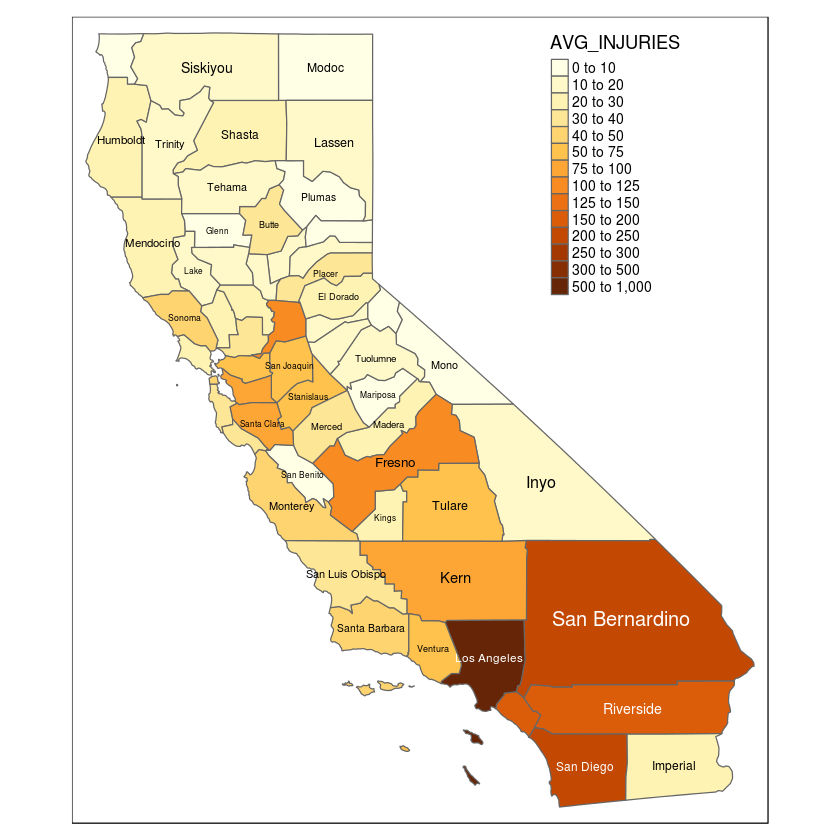

In [30]:
qtm(US_California_CO, fill = "AVG_INJURIES", 
    text="NAME", 
    text.size = "AREA", 
    fill.style="fixed", 
    fill.breaks=c(0,10,20,30,40,50,75,100,125,150, 200, 250, 300, 500, 1000)
   )

Haritadan kazalardaki yaralanma/ölmelerin bölge ile olan ilişkisi açıkça görülüyor. *geotypevalue* veya buna bağlı olan *county_name* değişkenlerinin model için faydalı olacağını çıkarabiliyoruz. Ayrıca güney bölgelerinin yaralanmalar açısından daha riskli bölgeler olduğunu düşünebiliriz. Fakat bu nüfus yoğunluğunun buralarda daha çok olmasından dolayı da olabilir. 

Böylece veriyi görsel olarak ifade ederek, bir tabloda kolayca göremeyeceğimiz ilişkileri görme şansı elde ettik. Bu konu son yıllarda büyük verinin görselleştirilmesi olarak oldukça ilgi çeken bir alan olarak hayli gelişti.

## Seyahat aracının yaralanmalar ile olan ilişkisi
[Veri sözlüğü](https://cdph.data.ca.gov/api/views/xmwz-xvsf/files/vFZ2-VvAdPb_6aOkATlLb19r3PpHHYGEgns1EH3kAQs?download=true&filename=RoadTrafficInjuries_DD.xlsx) nde verildiği üzere *mode* değişkeni kullanılan aracı gösteriyor. Bunlar;

* Bicyclist, 
* Bus, 
* Car/Pickup, 
* Motorcycle, 
* Pedestrian, 
* Truck, 
* Vehicles, 
* All modes, 
* ND=no data

değerlerini içerebiliyor. Bu değerler ile yaralanmalar arasındaki ilişkiyi incelemek için bir [ggplot2 boxplot](http://docs.ggplot2.org/current/geom_boxplot.html) kullanabiliriz.

In [31]:
### kurulum icin komut satirindan
#R -e 'install.packages(c("maps"))'
# admin yetkisi gerekiyorsa
#sudo R -e 'install.packages(c("maps"), lib="/usr/local/lib/R/site-library")'
library(ggplot2)

In [32]:
traffic_injuries_avg_CO_mode_d.f <- collect(
    agg(
        groupBy(traffic_injuries_CO_df, "mode"),
        AVG_INJURIES=avg(traffic_injuries_CO_df$AVG_INJURIES) 
    )
)
head(traffic_injuries_avg_CO_mode_d.f)

,mode,AVG_INJURIES
1,Truck,2.814433
2,Vehicles,113.1207
3,Bicyclist,10.41947
4,All modes,140.6686
5,Bus,2.40678
6,Motorcycle,19.92553


Karakter olan değişkeni [factor](http://www.programiz.com/r-programming/factor) yapma veri madenciliği çalışmalarında oldukça sık kullanılan bir yöntemdir.

In [33]:
traffic_injuries_avg_CO_mode_d.f$mode <- factor(
    traffic_injuries_avg_CO_mode_d.f$mode, 
    levels=c('Bicyclist','Bus','Car/Pickup','Motorcycle','Pedestrian',
             'Truck','Vehicles','All modes','ND=no data'),
    exclude = NA
)

In [34]:
str(traffic_injuries_avg_CO_mode_d.f)
class(traffic_injuries_avg_CO_mode_d.f)
levels(traffic_injuries_avg_CO_mode_d.f)

'data.frame':	8 obs. of  2 variables:
 $ mode        : Factor w/ 9 levels "Bicyclist","Bus",..: 6 7 1 8 2 4 3 5
 $ AVG_INJURIES: num  2.81 113.12 10.42 140.67 2.41 ...


[1] "data.frame"

NULL

In [37]:
traffic_injuries_CO_d.f <- collect(select(traffic_injuries_CO_df, "mode", "AVG_INJURIES"))

R data.frame e verimizi koyduk ve artık *ggplot* ile çizime hazırız.

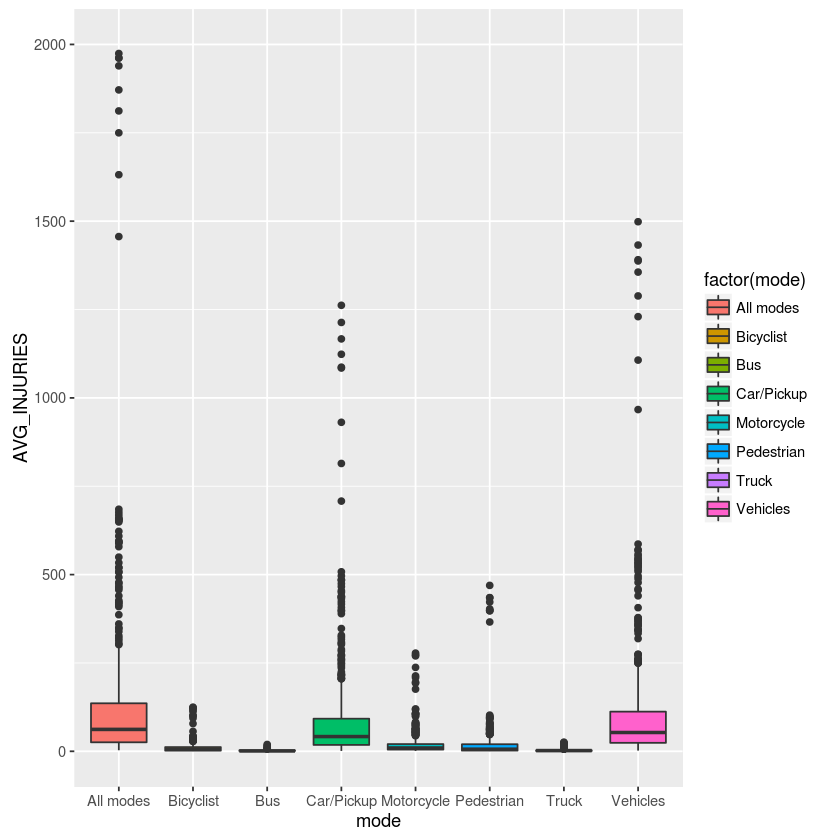

In [38]:
which_mode <- ggplot(data=traffic_injuries_CO_d.f, aes(x=mode, y=AVG_INJURIES))
which_mode + geom_boxplot(aes(fill=factor(mode))) + ylim(0,2000.0)

Seyahat için kullanılan araç tipi veya yaya olmak yaralanma ve kazalar açısından ayırd edici bir özelliğe sahip görünüyor. Bu nedenle modele katkısı olacağını düşünüyoruz. 

Esasen bu şekilde grafik bir çizim, veri boyutu büyüdükçe imkansız hale gelecektir. Bunun yerine Spark ile veri işlemeyi kullanarak veriyi toparlamak ve *SparkR* ile bazı karakteristik değerlerini incelemek daha uygun olacaktır. 

Şimdi bunu yapalım.

In [39]:
traffic_injuries_by_mode <- collect(agg(
    groupBy(traffic_injuries_CO_df,"mode"),
    AVG_INJURIES = avg(traffic_injuries_CO_df$AVG_INJURIES),
    MIN_INJURIES = min(traffic_injuries_CO_df$AVG_INJURIES),
    MAX_INJURIES = max(traffic_injuries_CO_df$AVG_INJURIES),
    SD_INJURIES = sd(traffic_injuries_CO_df$AVG_INJURIES),
    VAR_INJURIES = var(traffic_injuries_CO_df$AVG_INJURIES),
    N = count(traffic_injuries_CO_df$AVG_INJURIES)
))

Bu şekilde bir tablo ile sonuçları kontrol edebiliriz.

In [40]:
traffic_injuries_by_mode

,mode,AVG_INJURIES,MIN_INJURIES,MAX_INJURIES,SD_INJURIES,VAR_INJURIES,N
1,Truck,2.814433,1,26,3.550899,12.60889,388
2,Vehicles,113.1207,2,1498.5,195.4668,38207.27,522
3,Bicyclist,10.41947,1,125,17.02776,289.9447,416
4,All modes,140.6686,3,1974.5,263.5035,69434.11,522
5,Bus,2.40678,1,19.5,2.773462,7.69209,118
6,Motorcycle,19.92553,1,278,34.11095,1163.557,517
7,Car/Pickup,91.72989,1,1262,159.9192,25574.15,522
8,Pedestrian,23.19714,1,469.5,59.52726,3543.495,454


Buradan bu değişkenin de modelde işimize yarayabileceğini görebiliyoruz. Elimizdeki veriye göre en güvenli karada seyahat aracının otobüs olduğunu da görmüş oluyoruz.

## Nüfus ile yaralanmalar arasındaki ilişki
*totalpop* değişkeni coğrafi bölgeler kırılımında nüfusu veriyor. Bu değişkenin yaralanmaların sayısınının tahmininde önemli olacağını düşünüyoruz.

In [41]:
corr(traffic_injuries_CO_df, "AVG_INJURIES", "totalpop")

[1] 0.6157499

Korelasyon fonksiyonu *AVG_INJURIES* ve *totalpop* değişkenlerinin çok kuvvetli olmasada ilişkili olduğunu söylüyor. SparkR da ki bu fonksiyonlar R dakiler kadar çok sayıda olmasa da gün geçtikçe sayıları artıyor. Şimdi detaylara girelim.

Önce *describe* ile temel istatistik değerlere bakalım.

In [42]:
collect(describe(select(traffic_injuries_CO_df, "AVG_INJURIES","totalpop")))

,summary,AVG_INJURIES,totalpop
1,count,3459,3459
2,mean,59.81627638045678,714031.0818155536
3,stddev,153.29459007336328,1503546.5931305068
4,min,1.0,1175.0
5,max,1974.5,9818605.0


*Totalpop* değişkeninin analizini yapmak için grafik analiz ve istatistiksel analizi birlikte yapacağız.
Grafik analizde veri büyüklüğü ile başa çıkmak için bir örnek olsun diyerek örnekleme yapacağız.
Bu tür bir veri setinde örnekleme ile çalışmak için bir hayli detay çalışma yapmak gerekiyor. Örnekleme alt gruplar ve zaman boyutunu dikkate almalı. Fakat biz bu çalışma kapsamında basit olsun diye doğrudan rasgele örneklem alacağız.

Şimdi grafik analizi rahat yapabilmek için örnekleme yapalım. %10 veri ile çalışacağız. 

In [43]:
traffic_injuries_CO_sample_df <- sample(traffic_injuries_CO_df,
                                     withReplacement=FALSE, 
                                     fraction=0.1, 
                                     seed=1234)

Çalışacağımız kolonları alarak R ın data.frame yapısına geçelimki *ggplot* ile çizimlerimizi yapabilelim.

In [44]:
traffic_injuries_CO_totalpop_sample_d.f <- collect(select(traffic_injuries_CO_sample_df, 
                                                          "AVG_INJURIES", "totalpop"))

In [45]:
str(traffic_injuries_CO_totalpop_sample_d.f)

'data.frame':	324 obs. of  2 variables:
 $ AVG_INJURIES: num  2 144.5 91.5 273 99 ...
 $ totalpop    : num  69092 791065 2908736 1467150 222982 ...


In [46]:
summary(traffic_injuries_CO_totalpop_sample_d.f)

  AVG_INJURIES       totalpop      
 Min.   :   1.0   Min.   :   1211  
 1st Qu.:   4.0   1st Qu.:  63387  
 Median :  16.5   Median : 234144  
 Mean   :  67.4   Mean   : 746353  
 3rd Qu.:  52.5   3rd Qu.: 783064  
 Max.   :1750.0   Max.   :9818605  

Şimdi noktalama şeklinde grafiğimizi *ggplot* ve *geom_point* ile çizebiliriz.

Warning message:
: Removed 7 rows containing non-finite values (stat_smooth).Warning message:
: Removed 7 rows containing missing values (geom_point).

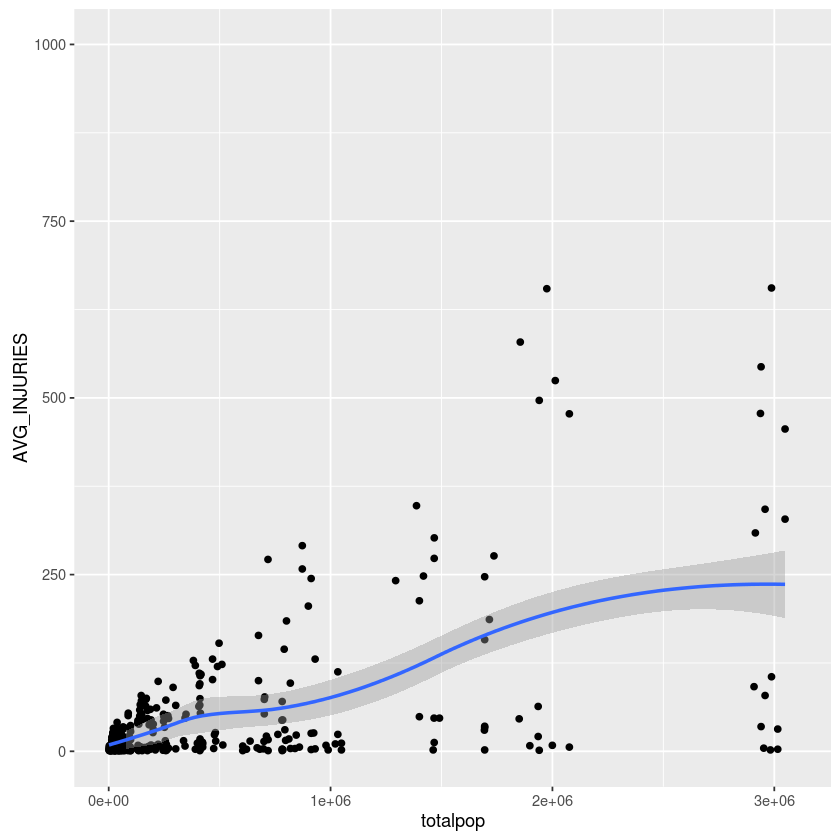

In [47]:
totalpop_chart <- ggplot(data=traffic_injuries_CO_totalpop_sample_d.f, aes(x=totalpop, y=AVG_INJURIES))
totalpop_chart + geom_point() + xlim(0,3.1e+06) + ylim(0,1000.0) + geom_smooth()

Buradan görünüyorki *totalpop* değeri arttıkça *AVG_INJURIES* de lineer artıyor. Fakat *totalpop* arttıkça noktaların saçılması varyansı artıyor. 

Burada analize bir boyut daha katıp açıklayamadığımız bu durumu anlamaya çalışalım. Bunu önce *mode* değişkeni bazında yapalım.

In [48]:
traffic_injuries_CO_totalpop_mode_sample_d.f <- collect(select(traffic_injuries_CO_sample_df, "AVG_INJURIES", "totalpop","mode"))
str(traffic_injuries_CO_totalpop_mode_sample_d.f)

'data.frame':	324 obs. of  3 variables:
 $ AVG_INJURIES: num  2 144.5 91.5 273 99 ...
 $ totalpop    : num  69092 791065 2908736 1467150 222982 ...
 $ mode        : chr  "Pedestrian" "All modes" "Pedestrian" "All modes" ...


Şimdi yeniden çizelim.

Warning message:
: Removed 231 rows containing non-finite values (stat_smooth).Warning message:
In simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : span too small.   fewer data values than degrees of freedom.Warning message:
In simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : pseudoinverse used at 44656Warning message:
In simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : neighborhood radius 18059Warning message:
In simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : reciprocal condition number  0Warning message:
In simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : There are other near singularities as well. 4.2231e+07Warning message:
In predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), : span too small.   fewer data values than degrees of freedom.Warning message:
In predLoess(obj

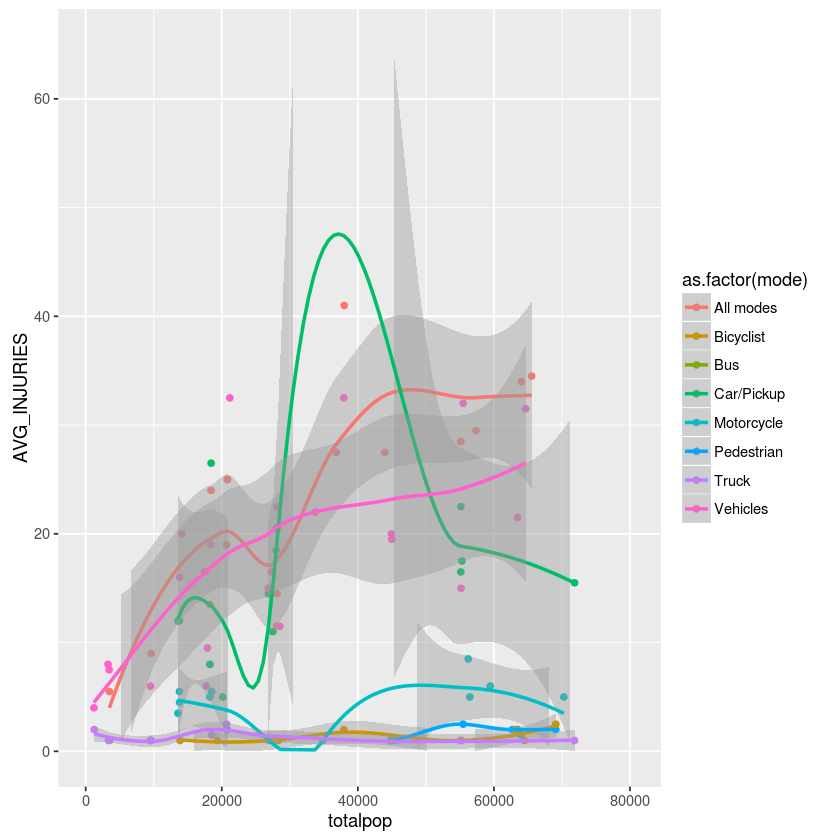

In [49]:
totalpop_mode_chart <- ggplot(data=traffic_injuries_CO_totalpop_mode_sample_d.f, aes(x=totalpop, y=AVG_INJURIES, colour=as.factor(mode)), na.rm = TRUE)
totalpop_mode_chart + geom_point() + ylim(0,65.0) + xlim(0,8.05E4) + geom_smooth()

Burada nüfus ile belli tip kazalarda yaralanmaların ilişkisi ortaya çıkıyor. Özellikle nüfus artışı ile göreceli olarak çok artmayanlarla lineer artanlar ayrışmış olarak görüyoruz.  İlişkini nonlineer olması mümkün.

İkinci olarak *Region* bazında bakalım.

In [52]:
traffic_injuries_totalpop_region <- collect(select(traffic_injuries_CO_sample_df, "AVG_INJURIES", "totalpop","region_name"))
str(traffic_injuries_totalpop_region)

'data.frame':	324 obs. of  3 variables:
 $ AVG_INJURIES: num  2 144.5 91.5 273 99 ...
 $ totalpop    : num  69092 791065 2908736 1467150 222982 ...
 $ region_name : chr  "Sacramento Area" "Bay Area" "San Diego" "Bay Area" ...


In [53]:
summary(traffic_injuries_totalpop_region)

  AVG_INJURIES       totalpop       region_name       
 Min.   :   1.0   Min.   :   1211   Length:324        
 1st Qu.:   4.0   1st Qu.:  63387   Class :character  
 Median :  16.5   Median : 234144   Mode  :character  
 Mean   :  67.4   Mean   : 746353                     
 3rd Qu.:  52.5   3rd Qu.: 783064                     
 Max.   :1750.0   Max.   :9818605                     

Warning message:
: Removed 2 rows containing non-finite values (stat_smooth).Warning message:
In simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : span too small.   fewer data values than degrees of freedom.Warning message:
In simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : pseudoinverse used at 2.1037e+05Warning message:
In simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : neighborhood radius 5175.5Warning message:
In simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : reciprocal condition number  0Warning message:
In simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : There are other near singularities as well. 4.5299e+07Warning message:
In predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), : span too small.   fewer data values than degrees of freedom.Warning message:
In predLoess

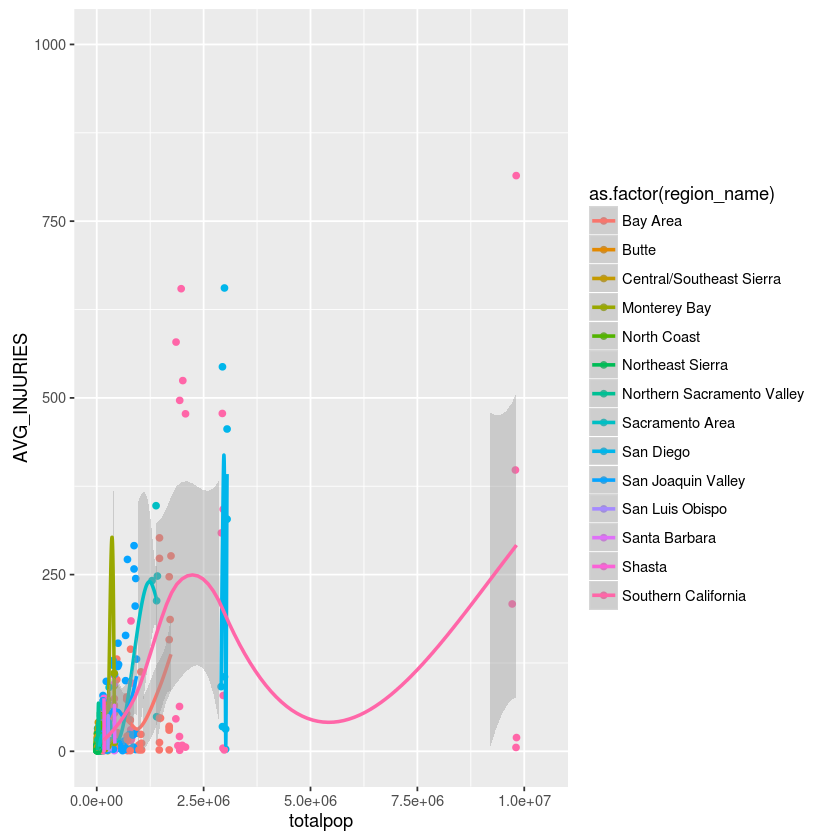

In [54]:
totalpop_county_chart <- ggplot(data=traffic_injuries_totalpop_region, aes(x=totalpop, y=AVG_INJURIES, colour=as.factor(region_name)), na.rm = TRUE)
totalpop_county_chart + geom_point() + xlim(0,1.05E7) + ylim(0,1000.0) + geom_smooth()

Burada da nonlineer bir ilişki varmış gibi duruyor ama örneklemeyi değişik seçerek bu durumu kontrol edebiliriz. Burada çok büyük olan değerleri kontrol etmek gerekiyor. Ama daha fazla uzatmamak için bitirelim.

# Kapanış düşünceleri
SparkR vasıtası ile R ın sahip olduğu zengin fonksiyonların büyük bir kısmını kullanamasak da, Spark ın paralel dağıtık mimaride büyük veri ile çalışabilme kabiliyetini R kullanıcılarının eline getiriyor. Yakın zamanda çok kullanılacak bir araç olacağını düşünüyorum.